In [1]:
import itertools
import pickle

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import seaborn as sns

import powerlaw

SAVE_DIR = "/path/to/dir/"

def plot_c(c,ax):
    ax.set_xlabel('year')
    ax.set_ylabel('# of Citation per year')
    ax.plot(range(len(c)),c,color='black')

# Prepare

In [20]:
with open(SAVE_DIR+'PHYS/dic_SBs_PHYS.pickle','rb') as f:
    dic_SBs = pickle.load(f)
with open(SAVE_DIR+'PHYS/dic_SBs_null_PHYS.pickle','rb') as f:
    dic_SBs_null = pickle.load(f)

In [18]:
names = {
    'glanzel': 'Naive',
    'raan': 'Average',
    'bornmann': 'DNIC',
    'ye': 'Citation Angle',
    'costas': 'Quartile',
    'li_exp': 'Boost Factor',
    'ke': 'Beauty Coefficient',
    'du': 'BC Cumulative Percentage',
    'wang': 'Citation Speed',
    'li': 'Adjusted Gini Coefficient',
    'teixeira': 'K-value',
    'null': 'null'
}

names_foriter = [
    'glanzel',
    'raan',
    'bornmann',
    'ye',
    'costas',
    'li_exp',
    'ke',
    'du',
    'wang',
    'li',
    'teixeira',
]

names_foriter_2 = [name for name in names_foriter if name != 'wang']
names_2 = names.copy()
del names_2['wang']
names_2['li'] = 'Citation Speed(Gini)'

colors = {n: cm.tab10(i) for i,n in enumerate(names_foriter_2) if n!='null'}
colors.update({'null': (0,0,0,1)})

In [19]:
# standard error
def conf(arr):
    '''
    99% confidence interval (2*standard error) from 2-dimensional array, assuming normal distribution
    '''
    arr_mean = arr.mean(axis=0)
    arr_conf_hi = arr_mean + 2.58*(arr.std(ddof=1,axis=0) / np.sqrt(len(arr)))
    arr_conf_low = arr_mean - 2.58*(arr.std(ddof=1,axis=0) / np.sqrt(len(arr)))
    return arr_mean, arr_conf_hi, arr_conf_low

# Analysis for Citation Feature

## Overlap

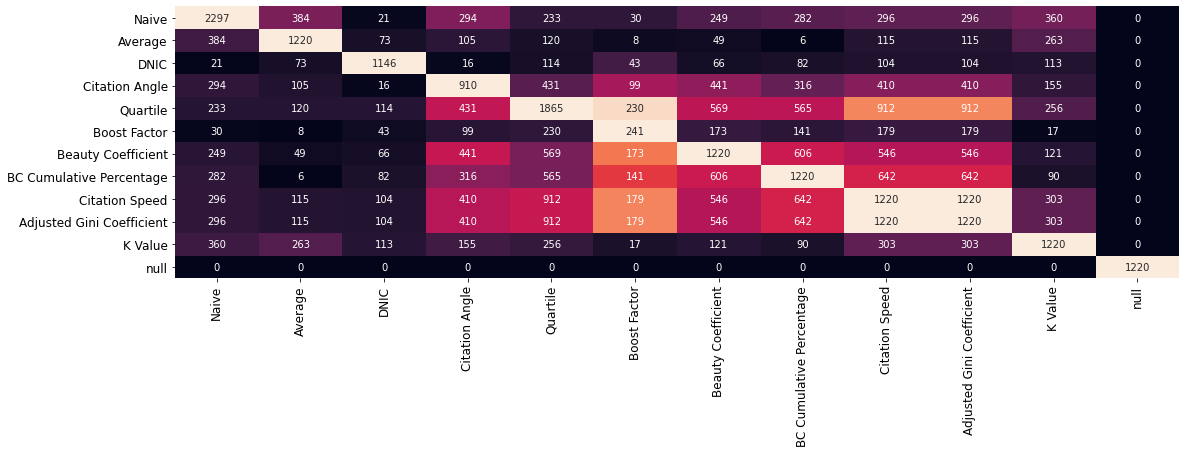

In [5]:
_1 = []
for k1 in names_foriter:
    _2 = []
    for k2 in names_foriter:
        _2.append(len(set(dic_SBs[k1].index)&set(dic_SBs[k2].index)))
    _2.append(0)
    _1.append(_2)
_1.append([0]*len(dic_SBs)+[len(dic_SBs_null[0])])
_ = pd.DataFrame(_1,index=[names[k] for k in names_foriter]+['null'],columns=[names[k] for k in names_foriter]+['null'])

fig,ax = plt.subplots(figsize=(18,5))
texts = _.to_numpy()
sns.heatmap(_/_.max(axis=0),annot=texts,fmt='d',cbar=False,ax=ax)
ax.tick_params(axis='both',labelsize=12)

# plt.savefig(SAVE_DIR + 'figs/PHYS/overlap.pdf', bbox_inches="tight", pad_inches=0.05,format='pdf')
plt.show()

## Publication Year

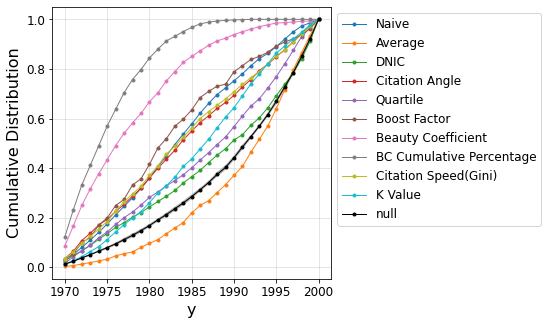

In [6]:
fig,ax = plt.subplots(figsize=(5,5))
x = range(1970,2001)
for k in names_foriter_2:
    y = dic_SBs[k]['year'].value_counts(normalize=True)
    ax.plot(x,np.cumsum(y.reindex(x).fillna(0).to_numpy()),marker=".",label=names_2[k],c=colors[k], linewidth=1) 

y_list = []
for i in dic_SBs_null:
    y = dic_SBs_null[i]['year'].value_counts(normalize=True)
    y_list.append(np.cumsum(y.reindex(x).fillna(0).to_numpy()))
y_mean, y_conf_hi, y_conf_low = conf(np.array(y_list))
ax.plot(x,y_mean,marker=".",label=names_2['null'],c=colors['null'], linewidth=1) 
ax.fill_between(x, y_conf_hi,y_conf_low, facecolor=colors['null'],alpha=0.3)
    
ax.grid(alpha=0.4)
ax.legend(fontsize=12,loc='upper left', bbox_to_anchor=(1,1))
ax.tick_params(axis='both',labelsize=12)
ax.set_xlabel('y',fontsize=16)
ax.set_ylabel('Cumulative Distribution',fontsize=16)
# plt.savefig(SAVE_DIR + 'figs/PHYS/year_distribution.pdf', bbox_inches="tight", pad_inches=0.05,format='pdf')
plt.show()

## Lifetime Citation

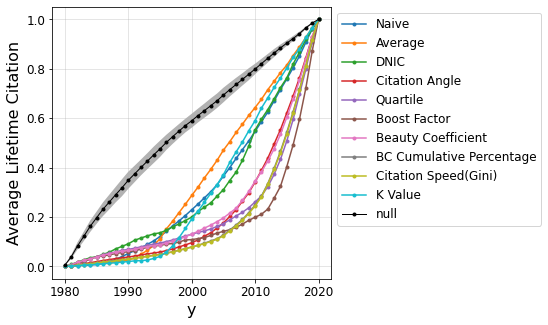

In [7]:
fig,ax = plt.subplots(figsize=(5,5))
year = 1980
x = np.arange(0,2021-year)

for k in names_foriter_2:
# for k in ['du','costas']:
    _ = dic_SBs[k][dic_SBs[k]["year"]==year].copy()
    ch_list = np.array(_['c_history_wo_self'].map(np.cumsum).to_list())
    ch_citation = _['citation_chwos'].to_numpy()
    ch_prop_mean = (ch_list/ch_citation.reshape(-1,1)).mean(axis=0)
    ax.plot(x,ch_prop_mean,label=names_2[k],c=colors[k],marker='.')

y_list = []
for i in dic_SBs_null:
    _ = dic_SBs_null[i][dic_SBs_null[i]["year"]==year].copy()
    ch_list = np.array(_['c_history_wo_self'].map(np.cumsum).to_list())
    ch_citation = _['citation_chwos'].to_numpy()
    ch_prop_mean = (ch_list/ch_citation.reshape(-1,1)).mean(axis=0)
    y_list.append(ch_prop_mean)
    
y_mean, y_conf_hi, y_conf_low = conf(np.array(y_list))
ax.plot(x,y_mean,marker=".",label=names_2['null'],c=colors['null'], linewidth=1) 
ax.fill_between(x, y_conf_hi,y_conf_low, facecolor=colors['null'],alpha=0.3)


ax.grid(alpha=0.4)
ax.legend(fontsize=12,loc='upper left', bbox_to_anchor=(1,1))
ax.tick_params(axis='both',labelsize=12)
ax.set_xticks([0,10,20,30,40])
ax.set_xticklabels([1980,1990,2000,2010,2020])
ax.set_xlabel('y',fontsize=16)
ax.set_ylabel('Average Lifetime Citation',fontsize=16)
# plt.savefig(SAVE_DIR+'figs/PHYS/year_citation_distribution_1980.pdf', bbox_inches="tight", pad_inches=0.05,format='pdf')
plt.show()

## Late Peak

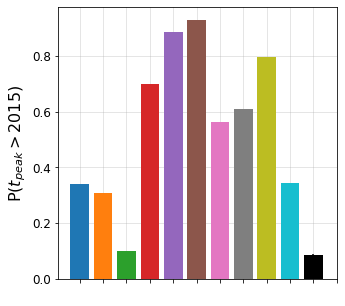

In [8]:
fig,ax  = plt.subplots(figsize=(5,5))
x = np.arange(11)
year = 2015
ys = []

for i,k in enumerate(names_foriter_2):
    y = ((dic_SBs[k]['c_history_wo_self'].map(np.argmax) + dic_SBs[k]['year']) > year).sum() / len(dic_SBs[k])
    ys.append(y)

ys_null = []
for i in dic_SBs_null:
    y = ((dic_SBs_null[i]['c_history_wo_self'].map(np.argmax) + dic_SBs_null[i]['year']) > year).sum() / len(dic_SBs[k])
    ys_null.append(y)
        
y_mean, y_conf_hi, y_conf_low = conf(np.array(ys_null))
ys.append(y_mean)

ax.bar(x,ys,yerr=[0]*10+[y_conf_hi-y_mean],ecolor='black',label=names_2['null'],color=colors.values(),zorder=10) 


ax.grid(alpha=0.4)
ax.tick_params(axis='both',labelsize=12)

ax.set_ylabel('P($t_{peak} >$' + str(year) + ')',fontsize=16)
ax.set_xticks(range(12))
ax.set_xticklabels([' ']*12)
# plt.savefig(SAVE_DIR + f'figs/PHYS/peak_{year}.pdf', bbox_inches="tight", pad_inches=0.05,format='pdf')
plt.show()

## Citation Distribution

Naive
(-625.7631555739422, 2.1367999658155054e-45)
Average
(-79.71651557613316, 0.011610282001841174)
DNIC
(35.05834295261737, 0.007624952593470773)


/usr/local/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in true_divide
  (CDF_diff**2) /
/usr/local/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning: divide by zero encountered in true_divide
  (CDF_diff**2) /


Citation Angle
(-412.6867992991807, 1.4626463768296623e-150)
Quartile
(1986.6992132052173, 1.4486720445113324e-07)
Boost Factor
(30.325071755212036, 0.010918076235650997)
Beauty Coefficient
(630.7620577478425, 0.00048359317166538215)
BC Cumulative Percentage
(682.1495670356796, 1.2380181241435692e-07)
Citation Speed(Gini)
(880.7983048489781, 3.943371009046863e-07)
K Value
(1011.4157726907852, 2.9277629747535938e-08)
null


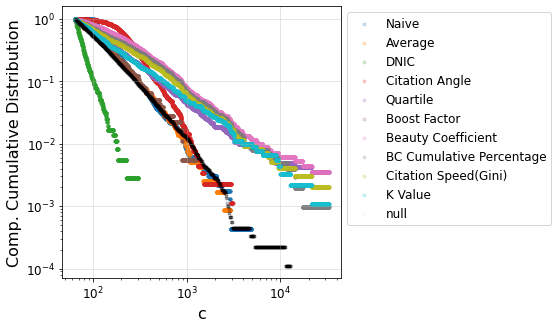

In [9]:
fig,ax = plt.subplots(figsize=(5,5))
for k in names_foriter_2:

    print(names_2[k])
    fit_results = powerlaw.Fit(dic_SBs[k]['citation_chwos'].to_numpy(),xmin=50)
    print(fit_results.distribution_compare('power_law', 'exponential')) #  positive=power_law, negative=exponential
    
    x = np.logspace(6,15,10000,base=2)
    y = dic_SBs[k]['citation_chwos'].to_numpy()
    y_binning = [np.count_nonzero((x[i]<=y)&(y<x[i+1])) for i in range(len(x)-1)] + [np.count_nonzero(y>=x[-1])]    
    ax.scatter(x,np.cumsum(y_binning[::-1])[::-1]/np.sum(y_binning),marker='.',color=colors[k],alpha=.2,label=names_2[k])

print('null')
y_list = []
for i in dic_SBs_null:
    x = np.logspace(6,15,10000,base=2)
    y = dic_SBs_null[i]['citation_chwos'].to_numpy()
    y_binning = [np.count_nonzero((x[i]<=y)&(y<x[i+1])) for i in range(len(x)-1)] + [np.count_nonzero(y>=x[-1])]    
    y_list.append(np.cumsum(y_binning[::-1])[::-1]/np.sum(y_binning))
y_mean, _, _ = conf(np.array(y_list))
ax.scatter(x,y_mean,marker='.',label=names_2['null'],color=colors['null'],alpha=.01)
    
ax.set_xlabel('c',fontsize=16)
ax.set_ylabel('Comp. Cumulative Distribution',fontsize=16)
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(axis='both',labelsize=12)
ax.grid(alpha=0.4)
ax.legend(fontsize=12,loc='upper left', bbox_to_anchor=(1,1))
# plt.savefig(SAVE_DIR+'figs/PHYS/citation_distribution.pdf', bbox_inches="tight", pad_inches=0.05,format='pdf')
plt.show()

## Team Size

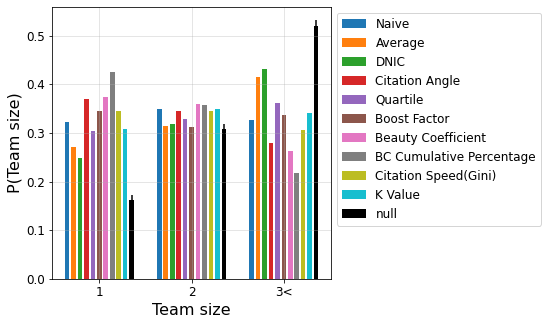

In [10]:
fig,ax = plt.subplots(figsize=(5,5))
x = np.arange(1,10)

for i,k in enumerate(names_foriter_2):
    y = dic_SBs[k]['authids'].map(lambda l: len(set(l))).value_counts(normalize=True)
    y1 = y.loc[1]
    y2 = y.loc[2]
    y3 = np.sum(y.reindex(range(3,21)).fillna(0).to_numpy())
    x = [j+(i*0.07) for j in range(3)]
    ax.bar(x,[y1,y2,y3],label=names_2[k],color=colors[k], width=.05) 

# null
y_list = []
for i in dic_SBs_null:
    y=dic_SBs_null[i]['authids'].map(lambda l: len(set(l))).value_counts(normalize=True)
    y1 = y.loc[1]
    y2 = y.loc[2]
    y3 = np.sum(y.reindex(range(3,21)).fillna(0).to_numpy())
    y_list.append([y1,y2,y3])        
y_mean, y_conf_hi, y_conf_low = conf(np.array(y_list))
ax.bar([j+((len(dic_SBs)-1)*0.07) for j in range(3)],y_mean,yerr=y_conf_hi-y_mean,label=names_2['null'],color=colors['null'], width=.05) 
    
ax.grid(alpha=0.4)
ax.legend(fontsize=12,loc='upper left', bbox_to_anchor=(1,1))
ax.tick_params(axis='both',labelsize=12)
ax.set_xlabel('Team size',fontsize=16)
ax.set_ylabel('P(Team size)',fontsize=16)
ax.set_xticks([0.35,1.35,2.35])
ax.set_xticklabels(['1','2','3<'])
# plt.savefig(SAVE_DIR + 'figs/PHYS/teamsize_bar.pdf', bbox_inches="tight", pad_inches=0.05,format='pdf')
plt.show()

## Early Citation Penalize

In [11]:
def is_overn_untilt(c_history:list, n:int, t:int) -> bool:
    """Returns whether the paper has been cited more than n times by year t"""
    return np.sum(c_history[:t+1])>=n

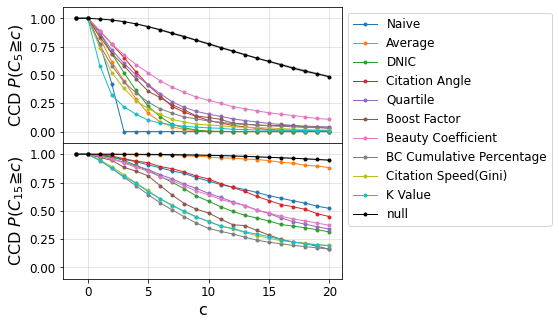

In [12]:
fig = plt.figure(figsize=(5,5))
gs = matplotlib.gridspec.GridSpec(2, 1, height_ratios=[1, 1]) 
gs1 = matplotlib.gridspec.GridSpecFromSubplotSpec(nrows=2,ncols=1, subplot_spec=gs[:,0])
axs = [fig.add_subplot(gs1[0,:])]
axs.append(fig.add_subplot(gs1[1,:], sharex = axs[0]))

y_maxs = [5,15]
x = np.linspace(-1,20,22)

for i,(y_max,ax) in enumerate(zip(y_maxs,axs)):
    for k in names_foriter_2:
        y=[dic_SBs[k]["c_history_wo_self"].map(lambda c_history: is_overn_untilt(c_history, n=int(xx), t=y_max)).sum()/len(dic_SBs[k]["c_history_wo_self"]) for xx in x]
        ax.plot(x,y,marker=".",label=names_2[k],c=colors[k],linewidth=1)
        ax.set_ylim(-0.1,1.1)
    
    y_list = []
    for i in dic_SBs_null:
        y=[dic_SBs_null[i]["c_history_wo_self"].map(lambda c_history: is_overn_untilt(c_history, n=int(xx), t=y_max)).sum()/len(dic_SBs_null[i]["c_history_wo_self"]) for xx in x]
        y_list.append(y)
        ax.set_ylim(-0.1,1.1)
    y_mean, y_conf_hi, y_conf_low = conf(np.array(y_list))
    ax.plot(x,y_mean,marker=".",label=names_2['null'],c=colors['null'], linewidth=1) 
    ax.fill_between(x, y_conf_hi,y_conf_low, facecolor=colors['null'],alpha=0.3)    
    ax.grid(alpha=0.4)
    
plt.setp(axs[0].get_xticklabels(), visible=False)
yticks = axs[1].yaxis.get_major_ticks()
yticks[-1].label1.set_visible(False)
axs[0].legend(fontsize=12,loc='upper left', bbox_to_anchor=(1,1))
axs[0].tick_params(axis='both',labelsize=12)
axs[1].tick_params(axis='both',labelsize=12)
axs[1].set_xlabel('c',fontsize=16)
plt.subplots_adjust(hspace=.0)

axs[0].set_ylabel('CCD $P(C_{5}\geqq c)$',fontsize=16)
axs[1].set_ylabel('CCD $P(C_{15}\geqq c)$',fontsize=16)
# plt.savefig(SAVE_DIR+f'figs/PHYS/early_penalize.pdf', bbox_inches="tight", pad_inches=0.05,format='pdf')
plt.show()

## Transition Jump

In [13]:
def slope(c):
    c_max = max(c)
    diff_max = max(np.diff(c))
    return diff_max/c_max

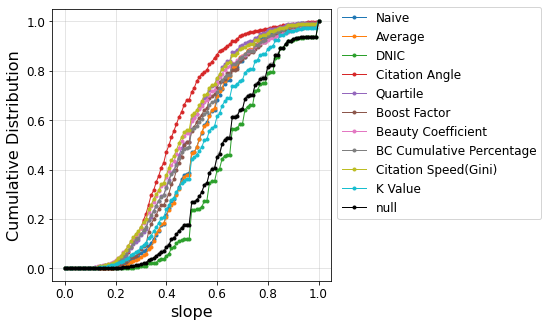

In [14]:
for k in names_foriter_2:
    dic_SBs[k]["slope"] = dic_SBs[k]["c_history_wo_self"].map(slope)
for i in dic_SBs_null:
    dic_SBs_null[i]["slope"] = dic_SBs_null[i]["c_history_wo_self"].map(slope)

fig,ax = plt.subplots(figsize=(5,5))
x = np.linspace(0,1,101)
for k in names_foriter_2:
    y = dic_SBs[k]["slope"].to_numpy()
    y_binning = [np.count_nonzero((x[i]<=y)&(y<x[i+1])) for i in range(len(x)-1)] + [np.count_nonzero(y==x[-1])]
    ax.plot(x,np.cumsum(y_binning)/np.sum(y_binning),marker=".",label=names_2[k],c=colors[k],linewidth=1)
    
y_list = []
for i in dic_SBs_null:
    y = dic_SBs_null[i]["slope"].to_numpy()
    y_binning = [np.count_nonzero((x[i]<=y)&(y<x[i+1])) for i in range(len(x)-1)] + [np.count_nonzero(y==x[-1])]
    y_list.append(np.cumsum(y_binning)/np.sum(y_binning))
y_mean, y_conf_hi, y_conf_low = conf(np.array(y_list))
ax.plot(x,y_mean,marker=".",label=names_2['null'],c=colors['null'], linewidth=1) 
ax.fill_between(x, y_conf_hi,y_conf_low, facecolor=colors['null'],alpha=0.3)         
    
    
ax.grid(alpha=0.4)
ax.legend(fontsize=12,bbox_to_anchor=(1, 1.03))
ax.tick_params(axis='both',labelsize=12)
ax.set_xlabel('slope',fontsize=16)
ax.set_ylabel('Cumulative Distribution',fontsize=16)
# plt.savefig(SAVE_DIR+'figs/PHYS/slope.pdf', bbox_inches="tight", pad_inches=0.05,format='pdf')
plt.show()

## Hibernators obtained by only one method

In [15]:
def plot_c2(year,c,ax):
    ax.set_xlabel('year')
    ax.set_ylabel('# of Citation per year')
    ax.plot(range(year,year+len(c)),c,color='black',marker='.')
    ax.set_xlim(1970,2021)
    ax.grid(alpha=0.4)

glanzel
(1317, 19)


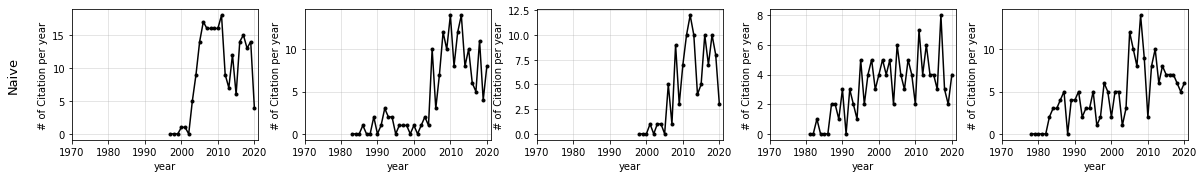

raan
(605, 19)


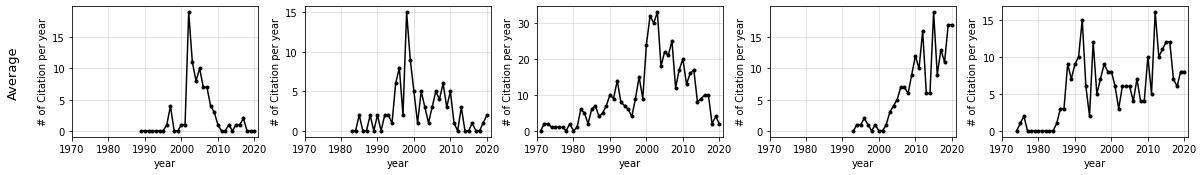

bornmann
(810, 19)


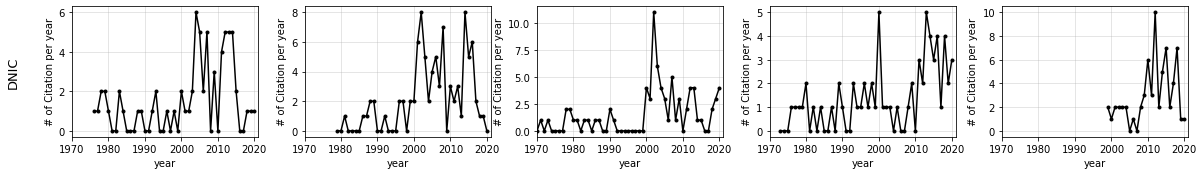

ye
(152, 19)


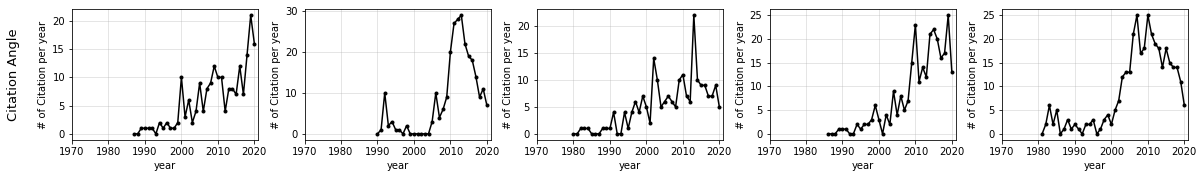

costas
(592, 20)


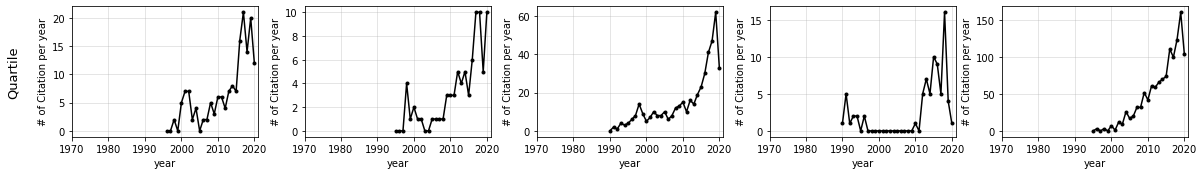

li_exp
(3, 19)


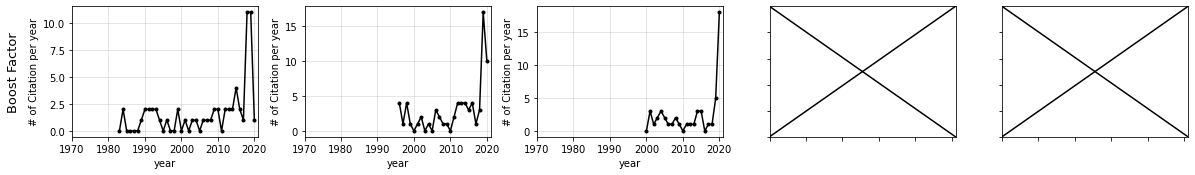

ke
(260, 19)


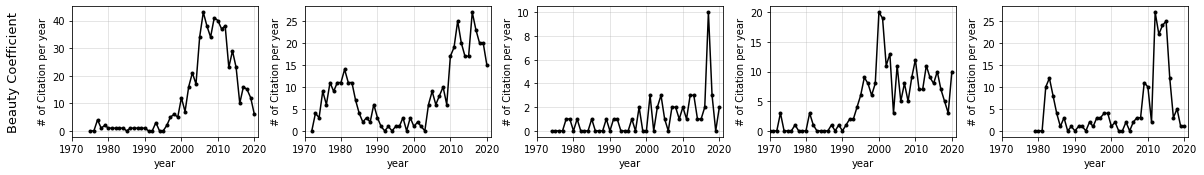

du
(211, 20)


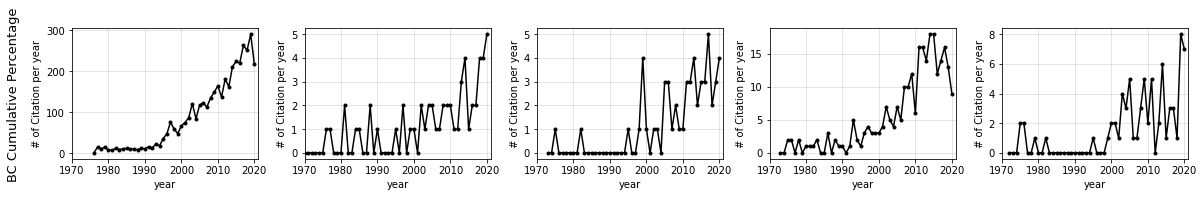

li
(41, 20)


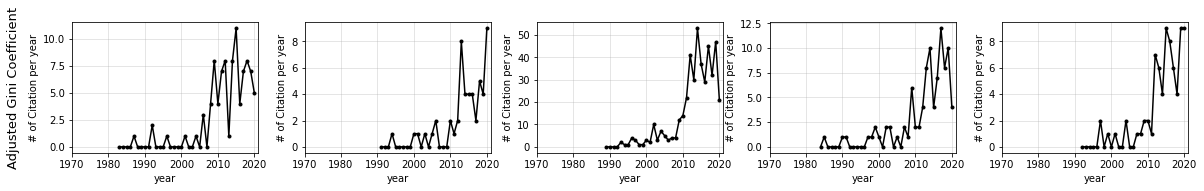

teixeira
(458, 20)


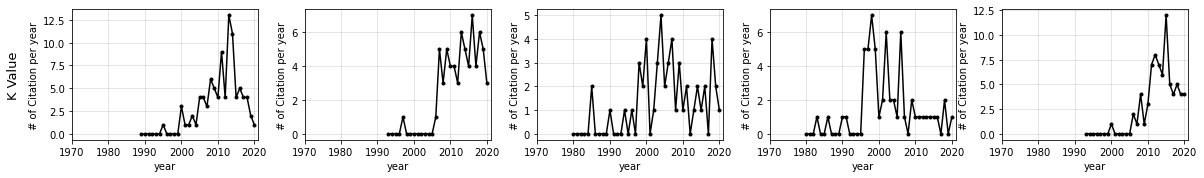

In [16]:
N_DISPLAY = 5
for target_name in names_foriter_2:
    fig = plt.figure(figsize=(20,2.4))
    fig.subplots_adjust(wspace=0.25, hspace=0)
    target_eids = set(dic_SBs[target_name].index) - set(list(itertools.chain.from_iterable([dic_SBs[k].index for k in names_foriter_2 if k != target_name])))
    df = dic_SBs[target_name].reindex(list(target_eids))
    print(target_name)
    print(df.shape)
    if len(df) < N_DISPLAY:
        for i,(_,row) in enumerate(df[['year','c_history_wo_self']].iterrows()):
            ax = fig.add_subplot(1,N_DISPLAY,i+1)
            plot_c2(row['year'],row['c_history_wo_self'],ax)
        for i in range(len(df), N_DISPLAY):
            ax = fig.add_subplot(1,N_DISPLAY,i+1)
            ax.set_xlim(1970,2021)
            ax.set_ylim(0,10)
            ax.set_xticks(range(1970,2021,10))
            ax.set_yticks(range(0,10,2))
            ax.set_xticklabels([' ' for _ in ax.get_xticks()])
            ax.set_yticklabels([' ' for _ in ax.get_yticks()])
            ax.plot([1970,2021],[0,10],color='black')
            ax.plot([1970,2021],[10,0],color='black')
    else:
        for i,(_,row) in enumerate(df.sample(N_DISPLAY,random_state=0)[['year','c_history_wo_self']].iterrows()):
            ax = fig.add_subplot(1,N_DISPLAY,i+1)
            plot_c2(row['year'],row['c_history_wo_self'],ax)
    fig.text(0.08,0.5, f'{names[target_name]}',fontsize=13, rotation='vertical',verticalalignment='center')
#     plt.savefig(SAVE_DIR+f'figs/PHYS/example/{target_name}.pdf', bbox_inches="tight", pad_inches=0.05,format='pdf')
    plt.show()

# Analysis for other bibliometric features

In [11]:
target_papers = pd.read_pickle(SAVE_DIR + 'PHYS/papers_arcp_subj_forpublic_features.pickle')
target_papers.shape

(8122477, 4)

In [51]:
target_papers.head()

,ref_single_subj_forcited,citation_single_subj_forcited,ref_journals,D
eid,,,,
85073619453,"[PHYS, PHYS, PHYS, PHYS, PHYS, PHYS, PHYS, PHY...","[PHYS, PHYS, PHYS, PHYS]","[29086, 28520, 21100779241, 110157, 28520, 285...",-0.001970
85073489235,"[MATE, MATE, MATE, MATE, MATE, MATE, MATE, MAT...",[],"[20540, 13554, 27454, 28522, 20540, 15995, 274...",NaN
85073489247,"[PHYS, ENGI, PHYS, PHYS, PHYS, CHEM, PHYS, PHY...",[CHEM],"[11000153773, 21100403931, 27551, 29118, 85318...",-0.000007
85073619521,"[PHYS, PHYS, PHYS, CHEM, PHYS, CHEM, PHYS, COM...","[CHEM, PHYS]","[26696, 28565, 27549, 26898, 19700190315, 3063...",-0.000172
85073556992,"[MATE, MATE, ENGI]",[],"[27854, 27854, 12202]",NaN


- column explanation
    - eid: int
        - Paper ID in Scopus Dataset
    - ref_single_subj_forcited: list[str]
        - All Science Journal Classification Codes for each reference journal
        - See "Appendix 1" in original paper for detail explanation
    - citation_single_subj_forcited: list[str]
        - All Science Journal Classification Codes for each cited journal
        - See "Appendix 1" in original paper for detail explanation
    - ref_journals: list[int]
        - Journal IDs for each reference journal
    - D: float
        - Disruption of the paper
        - If a paper has no citation, D = np.nan

In [25]:
for k in dic_SBs:
    dic_SBs[k] = pd.concat([dic_SBs[k],target_papers.reindex(dic_SBs[k].index)],axis=1)
for k in dic_SBs_null:
    dic_SBs_null[k] = pd.concat([dic_SBs_null[k],target_papers.reindex(dic_SBs_null[k].index)],axis=1)

## Interdisciplinarity

In [38]:
# disparity of each subj pair
disparity = np.load(SAVE_DIR + '3_diversity/PHYS/disparity_subjs_PHYS.npy')
dic_subj_toidx = pd.read_pickle(SAVE_DIR + '3_diversity/dic_subj_toidx.pickle')
dic_idx_tosubj = pd.read_pickle(SAVE_DIR + '3_diversity/dic_idx_tosubj.pickle')

In [39]:
def rs_paper(c: list,d: np.ndarray) -> float:
    """
    Returns the Rao-Stirling index of paper through its references.
    Parameters:
    ----------
        c : list[str]
            A list of subjects which the paper p references
        d[i][j]:  np.array
            Disparity of category i and j
            
    Returns:
    ----------
        rs: float
            Value of diversity of the paper
    """
    
    set_c = set(c)
    p = {subj:c.count(subj)/len(c) for subj in set_c}
    c_pairs = [pair for pair in itertools.permutations(set_c,2) if pair[0] != pair[1]]
    rs = sum([d[i][j]*p[i]*p[j] for i,j in c_pairs])
    
    return rs

In [47]:
#  example of reference interdisciplinarity of "2-s2.0-0000399209: Quantifying the properties of two-layer turbid media with frequency-domain diffuse reflectance"
print(rs_paper(c=[dic_subj_toidx[subj] for subj in target_papers.loc[399209,'ref_single_subj_forcited']],d=disparity))
#  example of reference interdisciplinarity of "2-s2.0-0000399209: Quantum inequivalence of different field representations"
print(rs_paper(c=[dic_subj_toidx[subj] for subj in target_papers.loc[84984793281,'ref_single_subj_forcited']],d=disparity))

0.6262025973795385
0


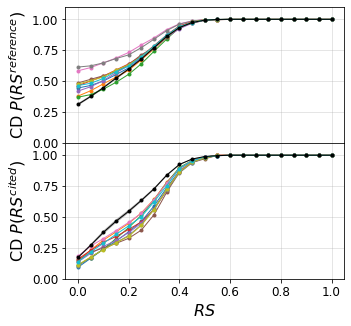

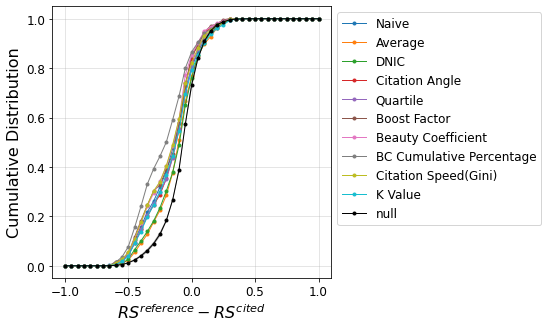

In [26]:
fig = plt.figure(figsize=(5,5))
gs = matplotlib.gridspec.GridSpec(2, 1, height_ratios=[1, 1]) 
gs1 = matplotlib.gridspec.GridSpecFromSubplotSpec(nrows=2,ncols=1, subplot_spec=gs[:,0])
ax1 = fig.add_subplot(gs1[0,:])
ax2 = fig.add_subplot(gs1[1,:], sharex = ax1)

x1 = np.linspace(0,1,21)
x2 = np.linspace(-1,1,41)

y_dic = dict()
y_null_dic = dict()

# reference rs
for k in names_foriter_2:
    y_ref = dic_SBs[k]["ref_single_subj_forcited"].map(lambda l: [dic_subj_toidx[subj] for subj in l]).to_list()
    y_cited = dic_SBs[k]["citation_single_subj_forcited"].map(lambda l: [dic_subj_toidx[subj] for subj in l]).to_list()
    
    y_rs_ref = np.array([rs_paper(l,d=disparity) for l in y_ref])
    y_rs_cited = np.array([rs_paper(l,d=disparity) for l in y_cited])
    y_rs_ref_cited = y_rs_ref - y_rs_cited

    y_rs_ref_binning = [np.count_nonzero((x1[i]<=y_rs_ref)&(y_rs_ref<x1[i+1])) for i in range(len(x1)-1)] + [np.count_nonzero(y_rs_ref==x1[-1])]
    y_rs_cited_binning = [np.count_nonzero((x1[i]<=y_rs_cited)&(y_rs_cited<x1[i+1])) for i in range(len(x1)-1)] + [np.count_nonzero(y_rs_cited==x1[-1])]
    y_rs_ref_cited_binning = [np.count_nonzero((x2[i]<=y_rs_ref_cited)&(y_rs_ref_cited<x2[i+1])) for i in range(len(x2)-1)] + [np.count_nonzero(y_rs_ref_cited==x2[-1])]
    
    ax1.plot(x1,np.cumsum(y_rs_ref_binning)/np.sum(y_rs_ref_binning),marker=".",label=names_2[k],c=colors[k],linewidth=1)
    ax1.set_ylabel('CD $P(RS^{reference})$',fontsize=16)
    ax2.plot(x1,np.cumsum(y_rs_cited_binning)/np.sum(y_rs_cited_binning),marker=".",label=names_2[k],c=colors[k],linewidth=1)
    ax2.set_ylabel('CD $P(RS^{cited})$',fontsize=16)
    y_dic[k] = np.cumsum(y_rs_ref_cited_binning)/np.sum(y_rs_ref_cited_binning)

# null
y_ref_list = []
y_cited_list = []
y_ref_cited_list = []
for i in dic_SBs_null:
    y_ref = dic_SBs_null[i]["ref_single_subj_forcited"].map(lambda l: [dic_subj_toidx[subj] for subj in l]).to_list()
    y_cited = dic_SBs_null[i]["citation_single_subj_forcited"].map(lambda l: [dic_subj_toidx[subj] for subj in l]).to_list()
    
    y_rs_ref = np.array([rs_paper(l,d=disparity) for l in y_ref])
    y_rs_cited = np.array([rs_paper(l,d=disparity) for l in y_cited])
    y_rs_ref_cited = y_rs_ref - y_rs_cited
    
    y_rs_ref_binning = [np.count_nonzero((x1[i]<=y_rs_ref)&(y_rs_ref<x1[i+1])) for i in range(len(x1)-1)] + [np.count_nonzero(y_rs_ref==x1[-1])]
    y_rs_cited_binning = [np.count_nonzero((x1[i]<=y_rs_cited)&(y_rs_cited<x1[i+1])) for i in range(len(x1)-1)] + [np.count_nonzero(y_rs_cited==x1[-1])]
    y_rs_ref_cited_binning = [np.count_nonzero((x2[i]<=y_rs_ref_cited)&(y_rs_ref_cited<x2[i+1])) for i in range(len(x2)-1)] + [np.count_nonzero(y_rs_ref_cited==x2[-1])]
    
    y_ref_list.append(np.cumsum(y_rs_ref_binning)/np.sum(y_rs_ref_binning))
    y_cited_list.append(np.cumsum(y_rs_cited_binning)/np.sum(y_rs_cited_binning))
    y_ref_cited_list.append(np.cumsum(y_rs_ref_cited_binning)/np.sum(y_rs_ref_cited_binning))
    
y_ref_mean, y_ref_conf_hi, y_ref_conf_low = conf(np.array(y_ref_list))
y_cited_mean, y_cited_conf_hi, y_cited_conf_low = conf(np.array(y_cited_list))
y_ref_cited_mean, y_ref_cited_conf_hi, y_ref_cited_conf_low = conf(np.array(y_ref_cited_list))

ax1.plot(x1,y_ref_mean,marker=".",label=names_2['null'],c=colors['null'], linewidth=1) 
ax1.fill_between(x1, y_ref_conf_hi,y_ref_conf_low, facecolor=colors['null'],alpha=0.3)
ax2.plot(x1,y_cited_mean,marker=".",label=names_2['null'],c=colors['null'], linewidth=1) 
ax2.fill_between(x1, y_cited_conf_hi,y_cited_conf_low, facecolor=colors['null'],alpha=0.3)
y_null_dic['mean'] = y_ref_cited_mean
y_null_dic['conf_hi'] = y_ref_cited_conf_hi
y_null_dic['conf_low'] = y_ref_cited_conf_low


plt.setp(ax1.get_xticklabels(), visible=False)
yticks = ax2.yaxis.get_major_ticks()
yticks[-1].label1.set_visible(False)

ax1.grid(alpha=0.4)
ax2.grid(alpha=0.4)

ax1.set_ylim(0,1.1)
ax2.set_ylim(0,1.1)

ax1.tick_params(axis='both',labelsize=12)
ax2.tick_params(axis='both',labelsize=12)

ax2.set_xlabel('$RS$',fontsize=16)
plt.subplots_adjust(hspace=.0)
# plt.savefig(SAVE_DIR+'figs/PHYS/rao_stirling.pdf', bbox_inches="tight", pad_inches=0.05,format='pdf')
plt.show()

fig,ax = plt.subplots(figsize=(5,5))

x2 = np.linspace(-1,1,41)

for k in names_foriter_2:
    ax.plot(x2,y_dic[k],marker=".",label=names_2[k],c=colors[k],linewidth=1)

# null 
ax.plot(x2,y_null_dic['mean'],marker=".",label=names_2['null'],c=colors['null'], linewidth=1) 
ax.fill_between(x2, y_null_dic['conf_hi'],y_null_dic['conf_low'], facecolor=colors['null'],alpha=0.3)

ax.grid(alpha=0.4)

ax.legend(fontsize=12,loc='upper left', bbox_to_anchor=(1,1))
ax.tick_params(axis='both',labelsize=12)
ax.set_xlabel('$RS^{reference}-RS^{cited}$',fontsize=16)
ax.set_ylabel('Cumulative Distribution',fontsize=16)
# plt.savefig(SAVE_DIR+'figs/PHYS/rao_stirling_ref_cited.pdf', bbox_inches="tight", pad_inches=0.05,format='pdf')
plt.show()

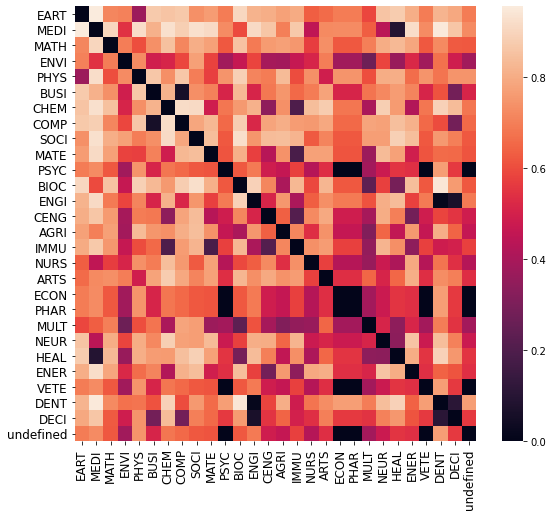

In [27]:
fig,ax = plt.subplots(figsize=(9,8))
sns.heatmap(disparity,ax=ax)
ax.set_xticklabels(dic_subj_toidx.keys(),rotation=90)
ax.set_yticklabels(dic_subj_toidx.keys(),rotation=0)
ax.tick_params(axis='both',labelsize=12)
# plt.savefig(SAVE_DIR+'figs/PHYS/disparity.pdf', bbox_inches="tight", pad_inches=0.05,format='pdf')
plt.show()

## Novelty

In [7]:
# z-score of each journal pair
with open(SAVE_DIR+'4_novelty/PHYS/z_ij_PHYS.pickle','rb') as f:
    z_ij = pickle.load(f)

#  example of novelty between "29143: Physical Review A" and "21100855841: Physical Review E"
print(z_ij[29143][21100855841])
#  example of novelty between "29143: Physical Review A" and "26987: Langmuir"
print(z_ij[29143][26987])

419.90048370450484
-250.0344112419687


In [30]:
def calc_z(l,frac=0.1):

    LARGE_Z = 2**63
    
    pairs = list(itertools.combinations(l,2))
    z_scores = np.array([z_ij[i][j] for (i,j) in pairs])
    if len(z_scores) == 0:
        return np.nan
    np.place(z_scores, z_scores == np.inf, LARGE_Z) 
    return np.percentile(z_scores,frac*100)

### z-10%

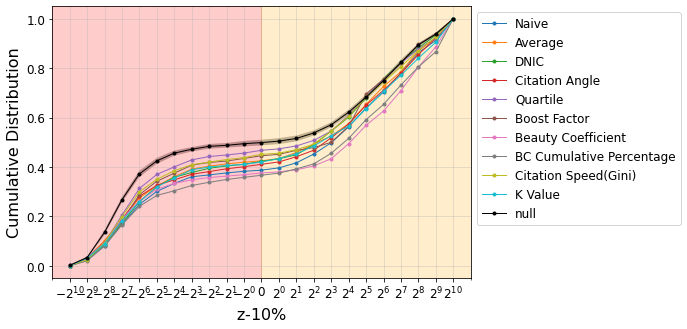

In [31]:
fig,ax = plt.subplots(figsize=(7.5,5))
x = np.concatenate([-np.logspace(10,0,11,base=2),np.array([0]),np.logspace(0,10,11,base=2)])

for k in names_foriter_2:
    y=dic_SBs[k]["ref_journals"]
    z = y.map(lambda l: calc_z(l,0.1))
    y_binning = [np.count_nonzero((x[i]<=z)&(z<x[i+1])) for i in range(len(x)-1)] + [np.count_nonzero(z>=x[-1])]    
    ax.plot(x,np.cumsum(y_binning)/np.sum(y_binning),marker=".",label=names_2[k],c=colors[k],linewidth=1)

# null
y_list = []
for i in dic_SBs_null:
    y=dic_SBs_null[i]["ref_journals"]
    z = y.map(lambda l: calc_z(l,0.1))
    y_binning = [np.count_nonzero((x[i]<=z)&(z<x[i+1])) for i in range(len(x)-1)] + [np.count_nonzero(z>=x[-1])]    
    y_list.append(np.cumsum(y_binning)/np.sum(y_binning))
y_mean, y_conf_hi, y_conf_low = conf(np.array(y_list))
ax.plot(x,y_mean,marker=".",label=names_2['null'],c=colors['null'], linewidth=1) 
ax.fill_between(x, y_conf_hi,y_conf_low, facecolor=colors['null'],alpha=0.3)        

ax.axvspan(-2**11, 0, color="red", alpha=0.2)
ax.axvspan(0, 2**11, color="orange", alpha=0.2)
ax.set_xlim(-2**11,2**11)
ax.grid(alpha=0.4)
ax.set_xscale('symlog',base=2)
ax.set_xticks(x)
ax.legend(fontsize=12,loc='upper left', bbox_to_anchor=(1,1))
ax.tick_params(axis='both',labelsize=12)
ax.set_xlabel('z-$10\%$',fontsize=16)
ax.set_ylabel('Cumulative Distribution',fontsize=16)
# plt.savefig(SAVE_DIR+'figs/PHYS/novelty_10.pdf', bbox_inches="tight", pad_inches=0.05,format='pdf')
plt.show()

### z-50%

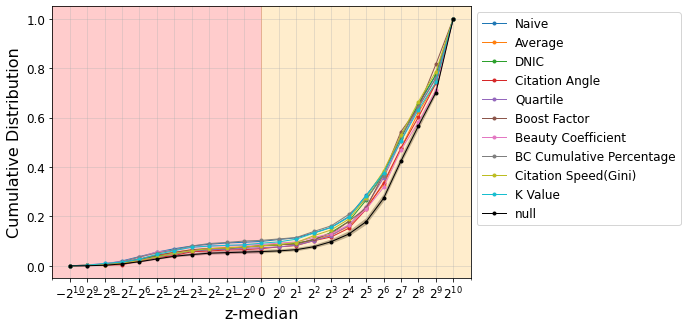

In [32]:
fig,ax = plt.subplots(figsize=(7.5,5))
x = np.concatenate([-np.logspace(10,0,11,base=2),np.array([0]),np.logspace(0,10,11,base=2)])

for k in names_foriter_2:
    y=dic_SBs[k]["ref_journals"]
    z = y.map(lambda l: calc_z(l,0.5))
    y_binning = [np.count_nonzero((x[i]<=z)&(z<x[i+1])) for i in range(len(x)-1)] + [np.count_nonzero(z>=x[-1])]    
    ax.plot(x,np.cumsum(y_binning)/np.sum(y_binning),marker=".",label=names_2[k],c=colors[k],linewidth=1)

# null
y_list = []
for i in dic_SBs_null:
    y=dic_SBs_null[i]["ref_journals"]
    z = y.map(lambda l: calc_z(l,0.5))
    y_binning = [np.count_nonzero((x[i]<=z)&(z<x[i+1])) for i in range(len(x)-1)] + [np.count_nonzero(z>=x[-1])]    
    y_list.append(np.cumsum(y_binning)/np.sum(y_binning))
y_mean, y_conf_hi, y_conf_low = conf(np.array(y_list))
ax.plot(x,y_mean,marker=".",label=names_2['null'],c=colors['null'], linewidth=1) 
ax.fill_between(x, y_conf_hi,y_conf_low, facecolor=colors['null'],alpha=0.3)     

ax.axvspan(-2**11, 0, color="red", alpha=0.2)
ax.axvspan(0, 2**11, color="orange", alpha=0.2)
ax.set_xlim(-2**11,2**11)
ax.grid(alpha=0.4)
ax.set_xscale('symlog',base=2)
ax.set_xticks(x)
ax.legend(fontsize=12,loc='upper left', bbox_to_anchor=(1,1))
ax.tick_params(axis='both',labelsize=12)
ax.set_xlabel('z-median',fontsize=16)
ax.set_ylabel('Cumulative Distribution',fontsize=16)
# plt.savefig(SAVE_DIR+'figs/PHYS/novelty_50.pdf', bbox_inches="tight", pad_inches=0.05,format='pdf')
plt.show()

## Disruption

In [30]:
#  example of disruption of  "2-s2.0-0011173192: Phase transformations during cooling in α + β titanium alloys"
print(target_papers.loc[11173192]['D'])
#  example of disruption of  "2-s2.0-26744476261: Variational bounds on energy dissipation in incompressible flows. II. Channel flow"
print(target_papers.loc[26744476261]['D'])

0.6277372262773723
-0.21532846715328466


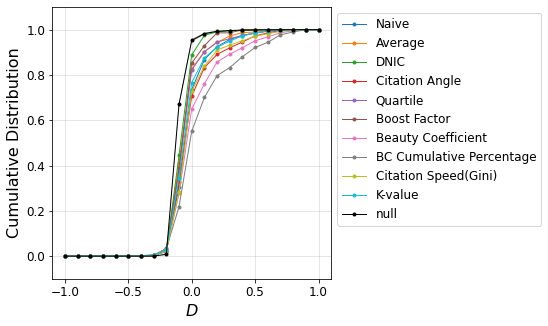

In [36]:
fig,ax = plt.subplots(figsize=(5,5))
x = np.linspace(-1,1,21)
for k in names_foriter_2:
    y=dic_SBs[k][dic_SBs[k]['target_years'].map(len)>=5]["D"]
    y_binning = [np.count_nonzero((x[i]<=y)&(y<x[i+1])) for i in range(len(x)-1)] + [np.count_nonzero(y==x[-1])]
    ax.plot(x,np.cumsum(y_binning)/np.sum(y_binning),marker=".",label=names_2[k],c=colors[k],linewidth=1)

# null
y_list = []
for i in dic_SBs_null:
    y=dic_SBs_null[i][dic_SBs_null[i]['target_years'].map(len)>=5]["D"]
    y_binning = [np.count_nonzero((x[i]<=y)&(y<x[i+1])) for i in range(len(x)-1)] + [np.count_nonzero(y==x[-1])]
    y_list.append(np.cumsum(y_binning)/np.sum(y_binning))
y_mean, y_conf_hi, y_conf_low = conf(np.array(y_list))
ax.plot(x,y_mean,marker=".",label=names_2['null'],c=colors['null'], linewidth=1) 
ax.fill_between(x, y_conf_hi,y_conf_low, facecolor=colors['null'],alpha=0.3)

ax.grid(alpha=0.4)
ax.set_ylim(-0.1,1.1)
ax.legend(fontsize=12,loc='upper left', bbox_to_anchor=(1,1))
ax.tick_params(axis='both',labelsize=12)
ax.set_xlabel('$D$',fontsize=16)
ax.set_ylabel('Cumulative Distribution',fontsize=16)
# plt.savefig(SAVE_DIR+'figs/PHYS/disruptiveness.pdf', bbox_inches="tight", pad_inches=0.05,format='pdf')
plt.show()